## Imports

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import json
import numpy as np
from itertools import count

# Experiment Loading Functions

In [2]:
def load_jsons(jsons_path, json_files):
    jsons = {}
    
    for subdir, dirs, files in os.walk(jsons_path):
        for file in files:
            for json_file in json_files:
                if file == json_file + ".json":
                    with open(os.path.join(subdir, file), 'r') as f:
                        assert json_file not in jsons, jsons_path + json_file
                        jsons[json_file] = json.load(f)
                        
    return jsons

In [3]:
def flatten_dictionary(dictionary):
    return pd.io.json.json_normalize(dictionary).to_dict(orient='records')[0]

In [4]:
def load_experiment(experiment_path, attack_folder_include, verbose=False):
    if verbose:
        print(experiment_path)
    experiment = {}
    
    target_jsons = ["metrics_train", "metrics_test", "training", "parameters"]
    attack_jsons = ["attack_parameters", "combined_metrics"]
    
    target_folders = [ f.name for f in os.scandir(experiment_path) if f.is_dir() and f.name.startswith('target')]
    attack_folders = [ f.name for f in os.scandir(experiment_path) if f.is_dir() and f.name.startswith(attack_folder_include or 'attack_20')]
    
    target_folders.sort()
    attack_folders.sort()
    
    if verbose:
        print(target_folders)
        print(attack_folders)
    
    for idx in range(len(target_folders)):
        experiment[idx] = {}
        experiment[idx]['target'] = load_jsons(os.path.join(experiment_path, target_folders[idx]), target_jsons)
        
        test_metrics = flatten_dictionary(experiment[idx]['target']['metrics_test'])
        train_metrics = flatten_dictionary(experiment[idx]['target']['metrics_train'])
        test_metrics = pd.DataFrame.from_dict(test_metrics, orient='index')
        train_metrics = pd.DataFrame.from_dict(train_metrics, orient='index')
        gap_metrics = train_metrics - test_metrics
        
        experiment[idx]['target']['gap_metrics'] = gap_metrics.to_dict()[0]
        
        experiment[idx] = flatten_dictionary(experiment[idx])

        experiment[idx]['target.gap_metrics.loss_gap'] = \
            experiment[idx]['target.metrics_test.loss'] / experiment[idx]['target.metrics_train.loss']
        
    for idx in range(len(attack_folders)):
        if verbose:
            print(attack_folders[idx])
        experiment[idx + len(target_folders)] = {}
        experiment[idx + len(target_folders)]['attacker'] = (load_jsons(os.path.join(experiment_path, attack_folders[idx]), attack_jsons))
        experiment[idx + len(target_folders)] = flatten_dictionary(experiment[idx + len(target_folders)])
        
    experiment_df = pd.DataFrame.from_dict(experiment, orient='index')
    
    parameters = [parameter for parameter in list(experiment_df.columns) 
              if "parameter" in parameter 
                  and not "seed" in parameter 
                  and not "path" in parameter
                  and not "save_model_freq" in parameter
                  and not "target_model_stacking" in parameter
                  and not "experiment_name" in parameter]
    for parameter in parameters:
        try:
            assert len(experiment_df[parameter].unique()) <= 2, parameter + " is not always the same!"
        except TypeError:
            pass

    # Check if right number of experiments was merged
    if experiment_path.endswith('nodp') and len(target_folders) != 3:
        print(f"Averaging {experiment_path.split('/')[-3:]} targets over {len(target_folders)} runs!")
    if not experiment_path.endswith('nodp') and len(target_folders) > 1:
        print(f"Averaging {experiment_path.split('/')[-3:]} targets over {len(target_folders)} runs!")
    if len(attack_folders) != 3:
        print(f"Averaging {experiment_path.split('/')[-3:]} attacks over {len(attack_folders)} runs!")
        
    experiment = experiment_df.iloc[0].to_dict()
    experiment.update(experiment_df.mean().to_dict())
    experiment.update(experiment_df.sem().add_suffix('_sem').to_dict())
    
    return experiment

In [5]:
def load_experiments_folder(path, attack_folder_include=None, verbose=False):
    experiments = {}
    
    subfolders = [ f.name for f in os.scandir(path) if f.is_dir() ]
    
    for subfolder in subfolders:
        if subfolder.startswith("target") or subfolder.startswith("attack"):
            return load_experiment(path, attack_folder_include, verbose)
            
    for subfolder in subfolders:
        if "_" not in subfolder:
            experiments[subfolder] = load_experiments_folder(os.path.join(path, subfolder), attack_folder_include, verbose)
    
    return experiments

In [6]:
model_names = ['BasicClf', 'WordCnn', 'bert-base-uncased']
model_name_to_print = {'BasicClf': 'BoW', 'WordCnn': 'CNN', 'bert-base-uncased': 'Transformer'}

### Calculate Meaningful Epsilon

In [7]:
from tensorflow_privacy.privacy.analysis.rdp_accountant import compute_rdp
from tensorflow_privacy.privacy.analysis.rdp_accountant import get_privacy_spent
import math
import numpy as np

def apply_dp_sgd_analysis(q, sigma, steps, orders, delta, warn):
    """Compute and print results of DP-SGD analysis."""
    rdp = compute_rdp(q, sigma, steps, orders)
    eps, _, opt_order = get_privacy_spent(orders, rdp, target_delta=delta)
    if (opt_order == max(orders) or opt_order == min(orders)) and warn:
        print('The privacy estimate is likely to be improved by expanding the set of orders.')

    return eps

def compute_dp_sgd_privacy(n, batch_size, noise_multiplier, epochs, warn=True):
    """Compute epsilon based on the given hyperparameters."""
    if(pd.isna(noise_multiplier)):
        return np.nan
        
    q = batch_size / n  # q - the sampling ratio.
    if q > 1:
        raise app.UsageError('n must be larger than the batch size.')
    orders = [1 + x / 100. for x in range(1, 1000)] + list(range(12, 64)) + [128, 256, 512]
    steps = int(math.ceil(epochs * n / batch_size))

    return apply_dp_sgd_analysis(q, noise_multiplier, steps, orders, 1/n, warn)

In [8]:
def get_dataframe_for_model(model_dict, warn=True):
    df = pd.DataFrame.from_dict(model_dict, orient='index')
    df['target.training.epsilon'] = df.apply(lambda row: \
                                             compute_dp_sgd_privacy(row['target.parameters.train_size'], 
                                                                    row['target.parameters.batch_size_train'], 
                                                                    row['target.parameters.noise_multiplier'], 
                                                                    row['target.training.best_epoch'],
                                                                    warn),
                                             axis=1)
    
    df.sort_values('target.parameters.noise_multiplier', ascending=True, na_position='first', inplace=True)

    return df

### Get dataframe with all experiments for given dataset

In [9]:
def get_dataframe_for_dataset(dataset_experiments):
    # Get noise multipliers and dataframes
    noise_multipliers_list = []
    dataframe_list = []
    for model_name in model_names:
        noise_multipliers_list.append(set(dataset_experiments[model_name].keys()))
        dataframe_list.append(get_dataframe_for_model(dataset_experiments[model_name]))
    
    # Intersect noise multipliers
    common_noise_multipliers = noise_multipliers_list[0] & \
                                noise_multipliers_list[1] & \
                                noise_multipliers_list[2]
    
    # Concat relevant rows
    dataset_df = pd.concat(dataframe_list, sort=False)
    
    # Consider MI baseline
    for mi_metric_id in ['accuracy', 'auc', 'average_precision']:
        mi_metric = 'attacker.combined_metrics.' + mi_metric_id
        #dataset_df.loc[(dataset_df[mi_metric] < 0.5), mi_metric] = 0.5 + randrange(0, 9) / 10000
        dataset_df[mi_metric] = dataset_df.apply(lambda row: row[mi_metric] if row[mi_metric] > 0.5 else 0.5, axis=1)
    
    for mi_metric_id in ['advantage']:
        mi_metric = 'attacker.combined_metrics.' + mi_metric_id
        #dataset_df.loc[(dataset_df[mi_metric] < 0), mi_metric] = 0.0 + randrange(0, 9) / 10000
        dataset_df[mi_metric] = dataset_df.apply(lambda row: row[mi_metric] if row[mi_metric] > 0.0 else 0.0, axis=1)
    
    # Make copy
    dataset_df_interpolated = None

    return dataset_df, dataset_df_interpolated

# Graph Functions

In [10]:
def plot_utility_metrics(dataset_df):
    dataset_name = dataset_df.iloc[0]['target.parameters.dataset']
    
    fig, axs = plt.subplots(nrows=1, ncols=3, sharey='row', sharex='col', figsize=(11,3))
    fig.tight_layout(pad=0)
    fig.subplots_adjust(wspace=0.15)
    
    utility_metrics = {
                   'target.metrics_test.global_measures_macro.accuracy': '$Acc$',
                   'target.metrics_test.hierarchical_measures.Hierarchical F1': '$F_H$',
                   'target.metrics_test.hierarchical_measures.LCA F': '$F_{LCA}$'
                   }
    x_axis = 'target.training.epsilon'
    linestyle_ls=['--',':','-.']
    markers_ms=['x','.','<']
    
    for idx, model_name in zip(count(),model_names):
        try:
            df = dataset_df[dataset_df['target.parameters.model_path'] == model_name].copy(deep=True)
            df['target.training.epsilon'].fillna(1e4, inplace=True)
            
            for (utility_metric, utlity_metric_name),ls_style, ms_marker in zip(utility_metrics.items(),linestyle_ls, markers_ms):
                axs[idx].plot(df[x_axis], df[utility_metric], 
                                  label=utlity_metric_name,
                                  linestyle=ls_style,
                                  marker=ms_marker
                                 )
            # Grid and ranges
            axs[idx].set_ylim(0.0, 1.0)
            axs[idx].grid()
            axs[idx].set_xlim(2e4, 0.1/2)
            axs[idx].set_xscale('log')
            
            # X labels with 'nodp'
            xtick_labels = ['nodp' if x == 4 else '$10^{' + str(x) + '}$' for x in range (-3, 7)]
            axs[idx].set_xticklabels(xtick_labels)
            axs[idx].minorticks_off()
            
        except KeyError as err:
            print("KeyError", err)

    cols = ['BoW', 'CNN', 'Transformer']
    for ax, col in zip(axs, cols):
        ax.set_title(col)
        
    for ax in axs:
        ax.set_xlabel('$\epsilon$')

    axs[1].legend(ncol=3, loc='center', fontsize=12, bbox_to_anchor=(0.5,-0.25))
    
    plt.savefig(f'{dataset_name}_utility.pdf', bbox_inches='tight')

    # show the plot
    plt.show()

In [11]:
def plot_mi_metrics(dataset_df):
    dataset_name = dataset_df.iloc[0]['target.parameters.dataset']
    #print("Train size", dataset_df.iloc[0]['target.parameters.train_size'])
    
    fig, axs = plt.subplots(nrows=2, ncols=3, sharey='row', sharex='all', figsize=(11,4))
    fig.tight_layout(pad=0)
    fig.subplots_adjust(wspace=0.15)

    x_axis = 'target.training.epsilon'
    bound_name = 'target.training.mi_adv_bound'
    metric_legend_1 = None
    metric_legend_2 = None
    bound_legend_2 = None
    
    print(dataset_name)
    
    for idx, model_name in enumerate(model_names):
        try:
            df = dataset_df[dataset_df['target.parameters.model_path'] == model_name].copy(deep=True)
            df[x_axis].fillna(1e4, inplace=True)
            
            # MI Metric 1
            mi_metric1 = 'attacker.combined_metrics.auc'
            metric_legend_1 = axs[0, idx].errorbar(df[x_axis], df[mi_metric1],
                                                    yerr=df[mi_metric1 + '_sem'],
                                                    capsize=3,
                                                   ls='--',
                                                    color='blue')
            # Grid
            axs[0, idx].grid()
            axs[0, idx].set_ylim(0.49, 0.65)
            
            # MI Metric 2
            mi_metric2 = 'attacker.combined_metrics.advantage'
            metric_legend_2 = axs[1, idx].errorbar(df[x_axis], df[mi_metric2],
                                                yerr=df[mi_metric2 + '_sem'],
                                                capsize=3,
                                                ls=':',
                                                color='red')
            
            # Bound
            eps = list(np.linspace(1e-2 ,np.log(2),100))
            adv_bound = list(np.exp(eps) - 1) 
            bound_legend_2 = axs[1, idx].plot([0] + eps + [1e5], [0] + adv_bound + [1], linestyle='-.',
                                              color='green')[0]
            
            # Grid
            axs[1, idx].grid()
            
            # Y
            axs[1, idx].set_ylim(-0.05, 1.05)
            
            # X
            axs[1, idx].set_xlim(2e4, 0.1/2)
            axs[1, idx].set_xscale('log')
            
            # X labels with 'nodp'
            xtick_labels = ['nodp' if x == 4 else '$10^{' + str(x) + '}$' for x in range (-3, 7)]
            #print(xtick_labels)
            #print(axs[1,idx].get_xticks())
            axs[1, idx].set_xticklabels(xtick_labels)
            axs[1, idx].minorticks_off()
            
        except KeyError as err:
            print("KeyError", err)

    cols = ['BoW', 'CNN', 'Transformer']
    for ax, col in zip(axs[0], cols):
        ax.set_title(col)
        
    for ax in axs[-1]:
        ax.set_xlabel('$\epsilon$')

    axs[1,1].legend([metric_legend_1, metric_legend_2, bound_legend_2], 
                    ['$AUC$', '$Adv$', 'Bound of $Adv$'], 
                    ncol=3, loc='center', fontsize=12, 
               bbox_to_anchor=(0.5, -0.37))
    
    # save the plot
    plt.savefig(f'{dataset_name}_mi.pdf', bbox_inches='tight')

    # show the plot
    plt.show()

# Graphs

### BestBuy

In [12]:
bestbuy_experiments = load_experiments_folder('/mnt/efs/DPTextHierarchy/logs/bestbuy_cleaned')

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


In [13]:
bestbuy_df, bestbuy_df_interpolated = get_dataframe_for_dataset(bestbuy_experiments)

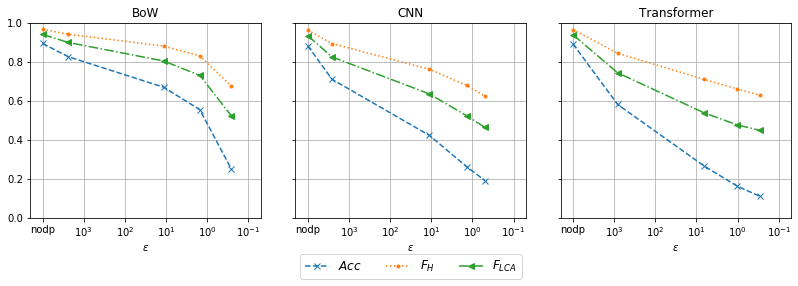

bestbuy_cleaned


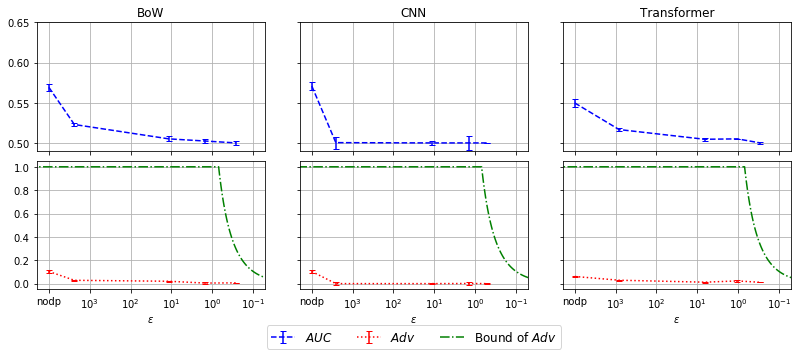

In [14]:
plot_utility_metrics(bestbuy_df)
plot_mi_metrics(bestbuy_df)

### Reuters

In [15]:
reuters_experiments = load_experiments_folder('/mnt/efs/DPTextHierarchy/logs/reuters')
reuters_df, reuters_df_interpolated = get_dataframe_for_dataset(reuters_experiments)

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


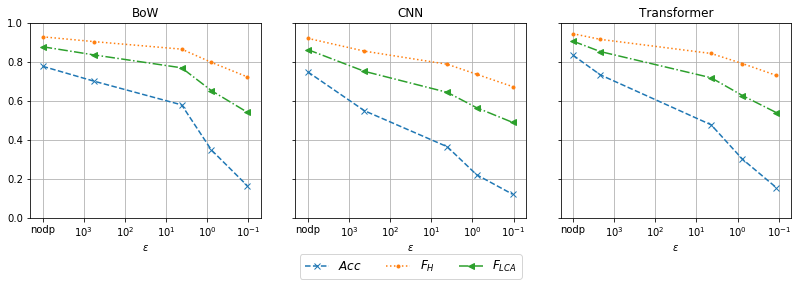

reuters


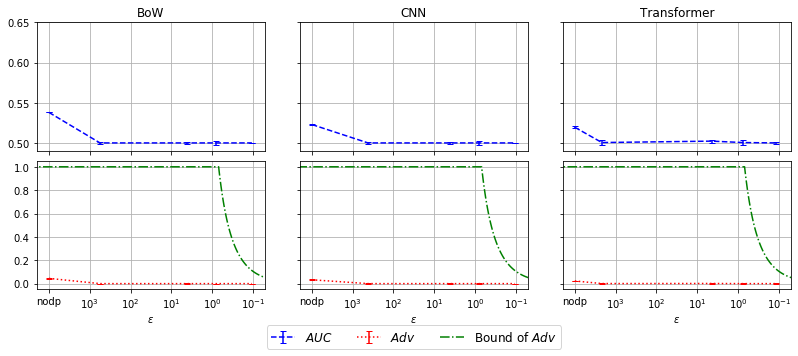

In [16]:
plot_utility_metrics(reuters_df)
plot_mi_metrics(reuters_df)

### DBPedia

In [17]:
dbpedia_experiments = load_experiments_folder('/mnt/efs/DPTextHierarchy/logs/DBPEDIA')
dbpedia_df, dbpedia_df_interpolated = get_dataframe_for_dataset(dbpedia_experiments)

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


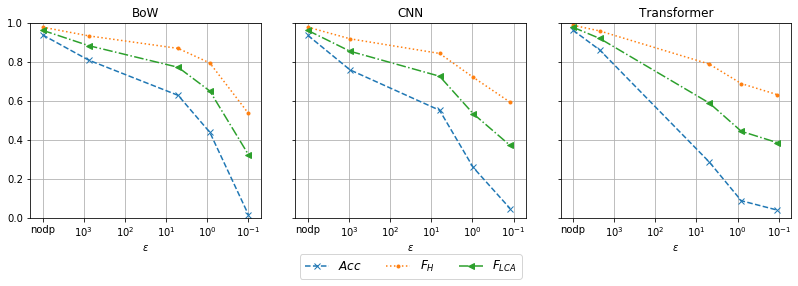

DBPEDIA


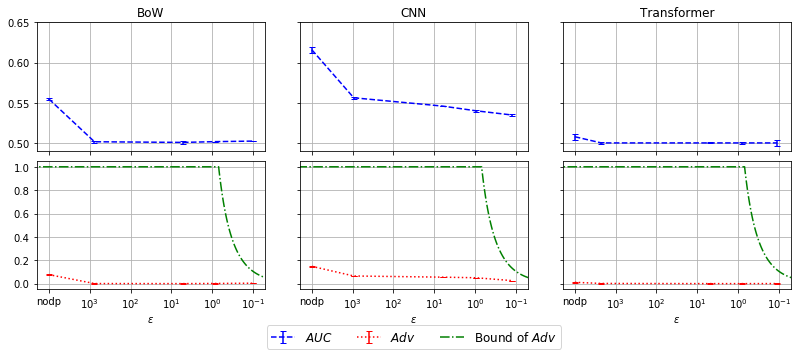

In [18]:
plot_utility_metrics(dbpedia_df)
plot_mi_metrics(dbpedia_df)

## Trade-Off Graphs

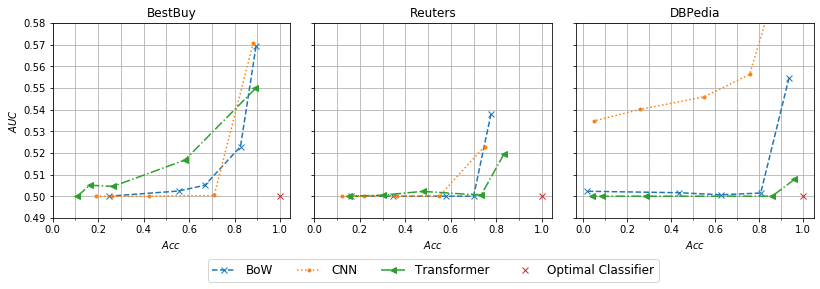

In [19]:
def plot_mi_tradeoff():
    fig, axs = plt.subplots(nrows=1, ncols=3, sharey='row', figsize=(11,3))
    fig.tight_layout(pad=0)
    fig.subplots_adjust(wspace=0.1)
    
    dfs = {'BestBuy': bestbuy_df, 'Reuters': reuters_df, 'DBPedia': dbpedia_df}

    x_axis = 'target.metrics_test.global_measures_macro.accuracy'
    y_axis = 'attacker.combined_metrics.auc'
    axs[0].set_ylabel('$AUC$')
    
    for idx, (name, dataset_df) in enumerate(dfs.items()):
        ax = axs[idx]
        ax.set_xlabel('$Acc$')
        ax.set_title(name)
        linestyle_ls=['--',':','-.']
        markers_ms=['x','.','<']
        for model_name,style_ls,marker_ms in zip(model_names,linestyle_ls,markers_ms):
            try:
                df = dataset_df[dataset_df['target.parameters.model_path'] == model_name].copy(deep=True)
                df[x_axis].fillna(1e4, inplace=True)

                ax.plot(df[x_axis], df[y_axis], marker=marker_ms,linestyle=style_ls, label=model_name_to_print[model_name])

            except KeyError as err:
                print("KeyError", err)

        ax.plot([1], [0.5], 'x', label='Optimal Classifier')
        ax.set_xticks([0.1*i for i in range (10)], minor=True)
        ax.grid(which='both')
        
    axs[0].set_ylim(0.49, 0.58)
    
    axs[1].legend(ncol=4, loc='center', fontsize=12,
             bbox_to_anchor=(0.5, -0.27))
    
    # save the plot
    plt.savefig('TradeOff.pdf', bbox_inches='tight')

    # show the plot
    plt.show()
    
plot_mi_tradeoff()